In [3]:
import pandas as pd

In [4]:
df = pd.read_csv("./experiment/experiment_log.csv")

((0.0, 1.0), (0.0, 1.0))

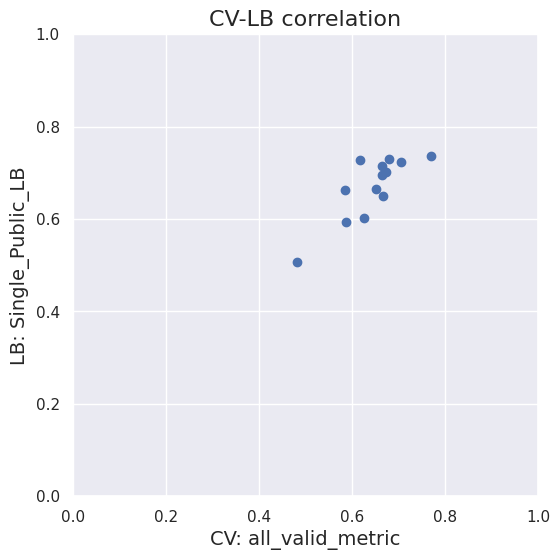

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
fig, ax = plt.subplots(1, 1, figsize=(6, 6), facecolor="white")

ax.scatter(df["all_valid_metric"], df["Single_Public_LB"])

ax.set_title("CV-LB correlation", fontsize=16)
ax.set_xlabel("CV: all_valid_metric", fontsize=14)
ax.set_ylabel("LB: Single_Public_LB", fontsize=14)
ax.set_xlim([0, 1]), ax.set_ylim([0, 1])